In [47]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [48]:
df_news = pd.read_csv("../data/apple_2023/news_apple_2023.csv", index_col=0)
df_price = pd.read_csv("../data/apple_2023/price_apple_2023.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2023-01-01 00:19:34  Title: iPhone 15 release date speculation: Her...
1 2023-01-01 01:25:56  Title: Apple (NASDAQ:AAPL) PT Set at $184.00 b...
2 2023-01-01 01:32:30  Title: 2023 Dividend Growth Portfolio Review A...
3 2023-01-01 02:52:26  Title: Tracking Terry Smith's Fundsmith 13F Po...
4 2023-01-01 03:10:16  Title: 5 appliances and smart home gadgets tha...
                 date       price
0 2023-01-03 09:31:00  129.058631
1 2023-01-03 09:32:00  128.929353
2 2023-01-03 09:33:00  128.740410
3 2023-01-03 09:34:00  129.307241
4 2023-01-03 09:35:00  129.108353


In [49]:
dfs = []
for i in range(1, 5):
    df_score = pd.read_csv(f"../data/apple_2023/news_score_apple_2023_{i}.csv", index_col=0)
    print(df_score.shape)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/apple_2023/news_score_apple_2023_all.csv")
df_score


# df_score = pd.read_csv(f"../data/apple_2023/news_score_apple_2023_{1}.csv", index_col=0)
# print(df_score.shape)
# df_score = df_score[["date", "score"]]
# df_score["date"] = pd.to_datetime(df_score['date'])

(2000, 3)


In [50]:
df_score = df_score.sort_values("date")
df_score.reset_index(drop = True, inplace = True)
df_score

,date,score
0,2023-01-01 00:19:34,1
1,2023-01-01 05:54:24,1
2,2023-01-01 14:20:37,0
3,2023-01-02 05:08:21,1
4,2023-01-02 09:50:11,1
...,...,...
1995,2023-07-10 15:27:29,1
1996,2023-07-10 16:58:26,1
1997,2023-07-10 18:51:41,1
1998,2023-07-11 00:41:20,1


In [51]:
df_score["score"].value_counts()

 1    1116
 0     544
-1     340
Name: score, dtype: int64

In [52]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [53]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [54]:
df_news.shape

(33152, 2)

In [55]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [56]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [57]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
110,2023-01-03 09:42:30,Title: Apple’s Magic Keyboard for 12.9-inch M2...,129.75474,1.0,-0.009235,-0.021383,-0.032955,-0.036787
120,2023-01-03 10:48:17,Title: Elon Musk Expresses Dissatisfaction Ove...,124.921754,-1.0,-0.001911,-0.000756,-0.003503,-0.006846
130,2023-01-03 11:40:47,Title: Jim Cramer's Investing Club meeting Tue...,124.613477,1.0,-0.002953,-0.004469,-0.003551,-0.005506
140,2023-01-03 12:46:46,Title: Apple's market value falls below $2 tri...,123.807979,-1.0,0.000803,0.000884,-0.002410,-0.002048
150,2023-01-03 13:06:14,Title: PayPal and Block Could Be ‘Comeback’ St...,123.798035,0.0,0.000723,-0.002330,0.002089,0.002089
...,...,...,...,...,...,...,...,...
19780,2023-07-07 14:34:12,Title: Best Buy Black Friday in July sale — 35...,191.807948,1.0,0.000312,-0.000416,0.000234,-0.002288
19910,2023-07-10 10:35:36,Title: Looking At Apple's Recent Unusual Optio...,187.908358,0.0,0.001221,0.001751,-0.001592,-0.001380
19920,2023-07-10 12:12:32,Title: 'Dino Dex': Prime Video & Canadian Nets...,186.661687,1.0,0.000107,0.001496,0.004061,0.004381
19930,2023-07-10 13:34:19,Title: Target takes on Prime Day with deep dea...,187.549317,1.0,0.000292,0.001064,-0.000160,0.001861


In [58]:
result_df = result_df.dropna()

In [59]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_24577/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,547,547,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
unique,542,544,522.000000,NaN,NaN,NaN,NaN,NaN
top,2023-03-23 12:16:31,Title: Here's How Much You Would Have Made Own...,160.728009,NaN,NaN,NaN,NaN,NaN
freq,2,2,2.000000,NaN,NaN,NaN,NaN,NaN
first,2023-01-03 09:42:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-07-10 14:53:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.510055,-0.000016,0.000061,0.000271,0.000176
std,NaN,NaN,NaN,0.704115,0.001577,0.002242,0.003623,0.004731
min,NaN,NaN,NaN,-1.000000,-0.012612,-0.021383,-0.032955,-0.036787
25%,NaN,NaN,NaN,0.000000,-0.000727,-0.000956,-0.001476,-0.001950


In [60]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [61]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [62]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,-0.081354,-0.032619,-0.015451,-0.001892
return_in5,-0.081354,1.000000,0.756397,0.457202,0.360082
return_in10,-0.032619,0.756397,1.000000,0.619859,0.482741
return_in20,-0.015451,0.457202,0.619859,1.000000,0.764949
return_in60,-0.001892,0.360082,0.482741,0.764949,1.000000


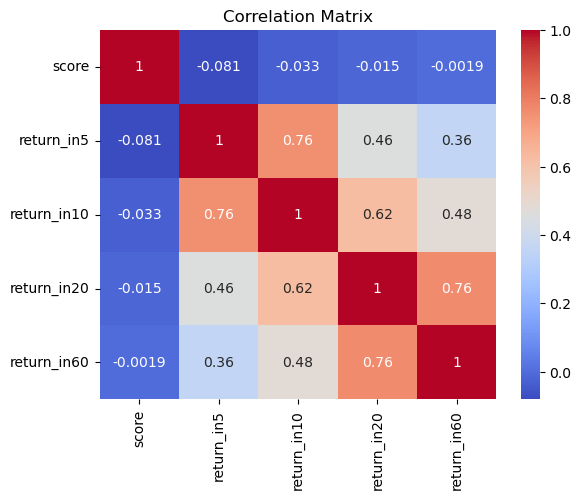

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

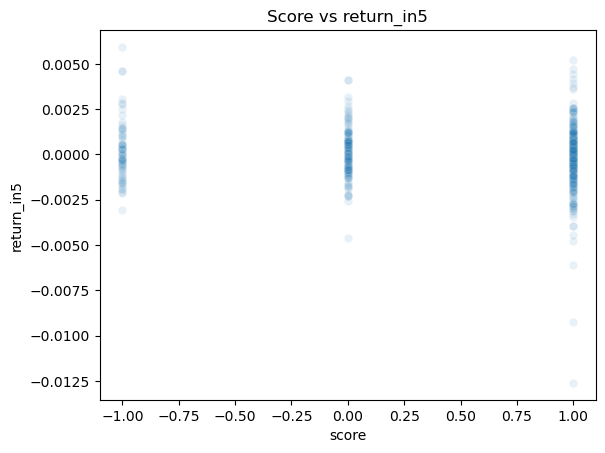

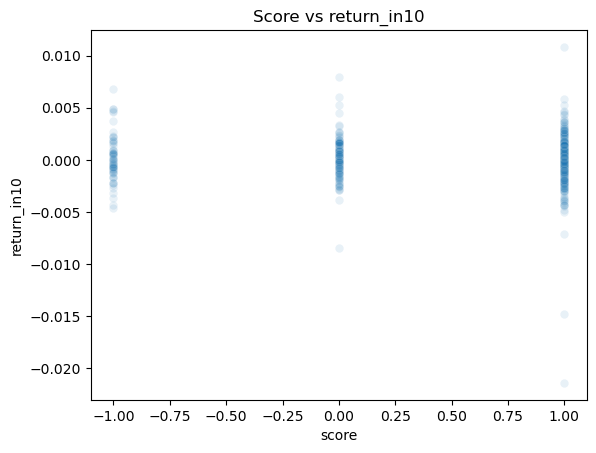

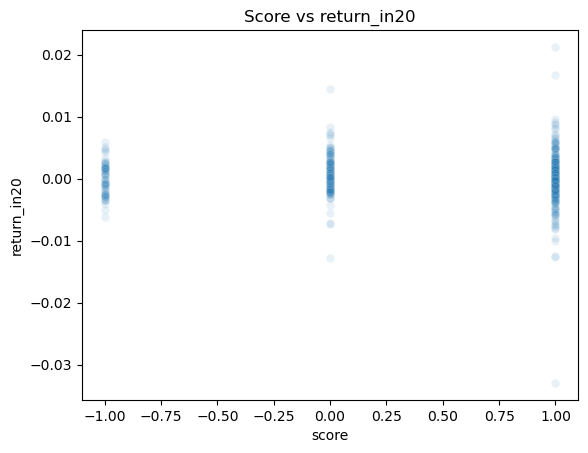

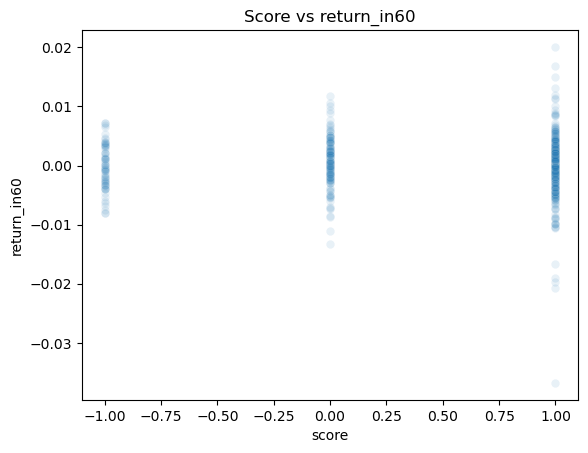

In [64]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=result_df, alpha=0.1)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [65]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(547, 4)

In [66]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [67]:
lr.coef_

array([[-1.82183241e-04],
       [-1.03873999e-04],
       [-7.95019622e-05],
       [-1.27085811e-05]])

In [68]:
return_names = ["return_in5", "return_in10","return_in20","return_in60"]
for name in return_names:
    for j in [-1, 0, 1]:
        print(f"When score is {j}, the mean {name} is {result_df[result_df['score'] == j][name].mean()*10000}")
    

When score is -1, the mean return_in5 is 2.130123534843085
When score is 0, the mean return_in5 is 1.2376765970899557
When score is 1, the mean return_in5 is -1.1388324082642898
When score is -1, the mean return_in10 is 1.458217108119791
When score is 0, the mean return_in10 is 1.8613256511726433
When score is 1, the mean return_in10 is -0.03793954691770487
When score is -1, the mean return_in20 is -0.36821303257918553
When score is 0, the mean return_in20 is 7.39254909270978
When score is 1, the mean return_in20 is 1.4912608848430493
When score is -1, the mean return_in60 is -2.298672091236148
When score is 0, the mean return_in60 is 6.069249256358304
When score is 1, the mean return_in60 is 0.8721663976797641
